# `Predicting Stroke Occurance Using KNN Classification` #
Gael Hernandez Palmer, Asha Octoman, Christina Yang, Julius Brooker

## Introduction ##

#### *Background Information:* #### 

Globally, stroke is the 2nd leading cause of death, accounting for approximately 11% of all deaths, according to the World Health Organisation (WHO). Through this project, we will attempt to find which health characteristics have the greatest effect on stroke occurrence, and construct a classification algorithm to accurately predict whether someone is likely to suffer a stroke based on their given characteristics. We will be using the “Stroke Prediction Dataset'' from Federico Soriano Palacios on Kaggle. This data set provides a number of observations including average blood glucose level, body mass index score, sex, and of course, history of strokes. We will use the data of these observations to find patterns between the health characteristics of a given person and construct an accurate model to predict the occurrence of strokes in other individuals given new data.

#### *Exploratory Question:* ####
Can a KNN classification model accurately predict the occurence of a stroke given patient data?

#### *Dataset:* ####
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

By: Federico Soriano Palacios

## Preliminary Data Analysis ##

In [2]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)

In [3]:
# loading data
stroke_url <- "https://raw.githubusercontent.com/Gaelhpalmer/dsci-100-project/main/data/stroke-data.csv"
stroke <- read_csv(stroke_url)
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [4]:
# cleaning and wrangling
stroke_clean <- stroke %>%
    select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
    mutate(gender = as_factor(gender), 
           bmi = as.numeric(bmi),
           smoking_status = as_factor(smoking_status),
           stroke = as_factor(stroke))

#     filter(gender != "Other") #other was removed as there was only one occurrence in the dataset

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [5]:
head(stroke_clean)

gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,228.69,36.6,formerly smoked,1
Female,61,0,0,202.21,NA,never smoked,1
Male,80,0,1,105.92,32.5,never smoked,1
Female,49,0,0,171.23,34.4,smokes,1
Female,79,1,0,174.12,24.0,never smoked,1
Male,81,0,0,186.21,29.0,formerly smoked,1


`summarise()` ungrouping output (override with `.groups` argument)



gender,n
<fct>,<int>
Male,2115
Female,2994
Other,1


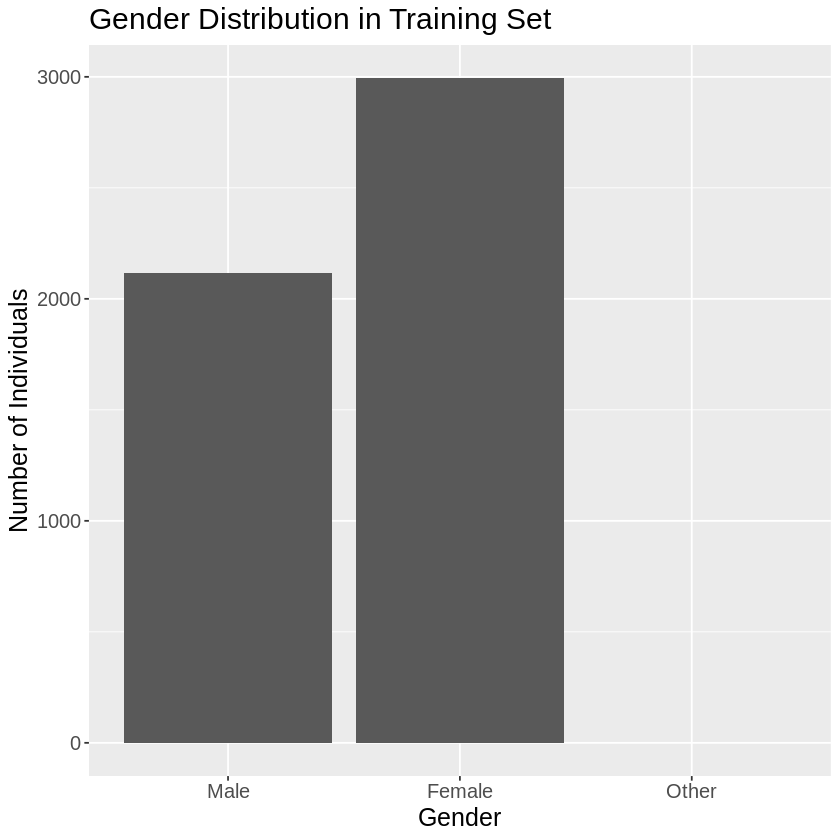

In [6]:
# Gender distribution
stroke_gender <- stroke_clean %>%
    group_by(gender) %>%
    summarize(n = n())

stroke_gender
    
stroke_gender_plot <- ggplot(stroke_gender, aes(x = gender, y = n)) +
    geom_bar(stat = "identity") +
    xlab("Gender") +
    ylab("Number of Individuals") +
    ggtitle("Gender Distribution in Training Set") +
    theme(text = element_text(size = 15))

stroke_gender_plot

 # Because there is only one occurance of Other in gender, we removed it from the data set
stroke_clean <- filter(stroke_clean, gender != "Other")

In [7]:
# Proportions of stroke observations in set
num_obs <- nrow(stroke_clean)
stroke_count <- stroke_clean %>%
  group_by(stroke) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
stroke_count

`summarise()` ungrouping output (override with `.groups` argument)



stroke,count,percentage
<fct>,<int>,<dbl>
0,4860,95.126248
1,249,4.873752


In [8]:
# data splitting
set.seed(1)

stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

#### Tables and Visualizations ####

In [9]:
# Proportions of stroke observations in training set

stroke_proportions <- stroke_clean %>%
    group_by(stroke) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/nrow(stroke_clean))

stroke_proportions

stroke_train_proportions <- stroke_train %>%
                      group_by(stroke) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(stroke_train))
stroke_train_proportions

stroke_test_proportions <- stroke_test %>%
                      group_by(stroke) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(stroke_test))
stroke_test_proportions

## The proportion of individuals experiencing stroke were maintained in the data splitting process.

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n,percent
<fct>,<int>,<dbl>
0,4860,95.126248
1,249,4.873752


`summarise()` ungrouping output (override with `.groups` argument)



stroke,n,percent
<fct>,<int>,<dbl>
0,3655,95.381002
1,177,4.618998


`summarise()` ungrouping output (override with `.groups` argument)



stroke,n,percent
<fct>,<int>,<dbl>
0,1205,94.361785
1,72,5.638215


In [10]:
# Binary data instances
# 0 indicates no, 1 indicates yes

stroke_hypertension <- stroke_train %>%
    group_by(hypertension) %>%
    summarize(n = n())
stroke_hypertension

stroke_heart_disease <- stroke_train %>%
    group_by(heart_disease) %>%
    summarize(n = n())
stroke_heart_disease



`summarise()` ungrouping output (override with `.groups` argument)



hypertension,n
<dbl>,<int>
0,3460
1,372


`summarise()` ungrouping output (override with `.groups` argument)



heart_disease,n
<dbl>,<int>
0,3638
1,194


In [11]:
# Numeric predictor variable means 

stroke_var_means <- stroke_train %>%
    summarize(mean_age = mean(age),
              mean_average_glucose_level = mean(avg_glucose_level), 
              mean_bmi = mean(bmi, na.rm = TRUE))

stroke_var_means

mean_age,mean_average_glucose_level,mean_bmi
<dbl>,<dbl>,<dbl>
43.31182,106.8061,28.96737


In [12]:
# Missing data
# Only column which is missing data is bmi (stated in the data description)

stroke_missing <- stroke_train %>%
    pivot_longer(bmi, names_to = "cols", values_to = "vals") %>%
    mutate(missing = is.na(vals)) %>%
    group_by(cols, missing) %>%
    summarise(num_missing = n()) %>%
    filter(missing==T) %>%
    select(-missing) 
stroke_missing

`summarise()` regrouping output by 'cols' (override with `.groups` argument)



cols,num_missing
<chr>,<int>
bmi,158


### Graphs

In [13]:
# graphs 
options(repr.plot.width = 5, repr.plot.height = 5)

We plotted hypertension, heart disease, and average glucose level against stroke as we wanted to visualize the relationship between our possible predictors and the target class. We used bar graphs for hypertension and heart disease, as they are binary, and therefore have discrete values. We used a histogram for average glucose level because the values for average glucose level are continuous. Instead of using a bar graph like we did for the rest of the potential predictors, we plotted age and bmi with a scatterplot and used color to show which observations had a stroke. We did this because this graph showed a greater correlation between the predictors and the target class compared to the individual histogram graph for age and bar graph for bmi. 

`summarise()` regrouping output by 'hypertension' (override with `.groups` argument)



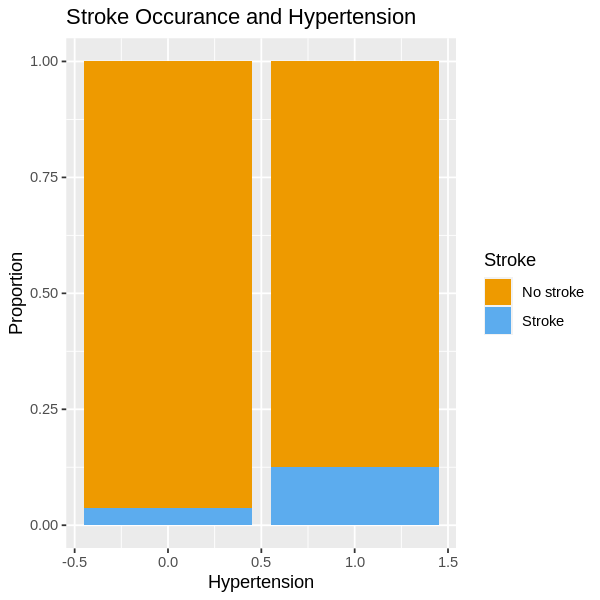

In [14]:
# hypertension
hypertension_count <- stroke_train %>% 
    group_by(hypertension, stroke) %>%
    summarise(n = n())

hypertension_plot <- ggplot(hypertension_count, aes(x = hypertension, y = n, fill = stroke)) + 
   geom_bar(stat = "identity", position = "fill") + 
  xlab("Hypertension") + 
  ylab("Proportion") + 
  ggtitle("Stroke Occurance and Hypertension") +
  labs(fill = "Stroke") +
  scale_fill_manual(labels = c("No stroke", "Stroke"), 
                         values = c("orange2", "steelblue2"))
hypertension_plot

The plot shows that the proportion of people with stroke are higher in people with hypertension compared to those without hypertension. This indicates that there is likely a positive relationship between stroke and hypertension.

`summarise()` regrouping output by 'heart_disease' (override with `.groups` argument)



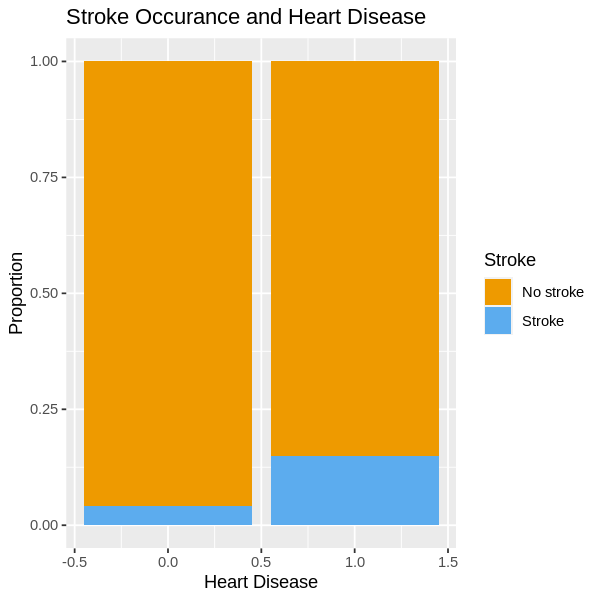

In [15]:
# heart disease
heart_disease_count <- stroke_train %>% 
    group_by(heart_disease, stroke) %>%
    summarise(n = n())

heart_disease_plot <- ggplot(heart_disease_count, aes(x = heart_disease, y = n, fill = stroke)) + 
   geom_bar(stat = "identity", position = "fill") + 
  xlab("Heart Disease") + 
  ylab("Proportion") + 
  ggtitle("Stroke Occurance and Heart Disease") +
  labs(fill = "Stroke") +
  scale_fill_manual(labels = c("No stroke", "Stroke"), 
                         values = c("orange2", "steelblue2"))
heart_disease_plot

The plot shows that the proportion of people with stroke are higher in people with heart disease compared to those without it. This indicates that there is likely a positive relationship between stroke and heart disease.

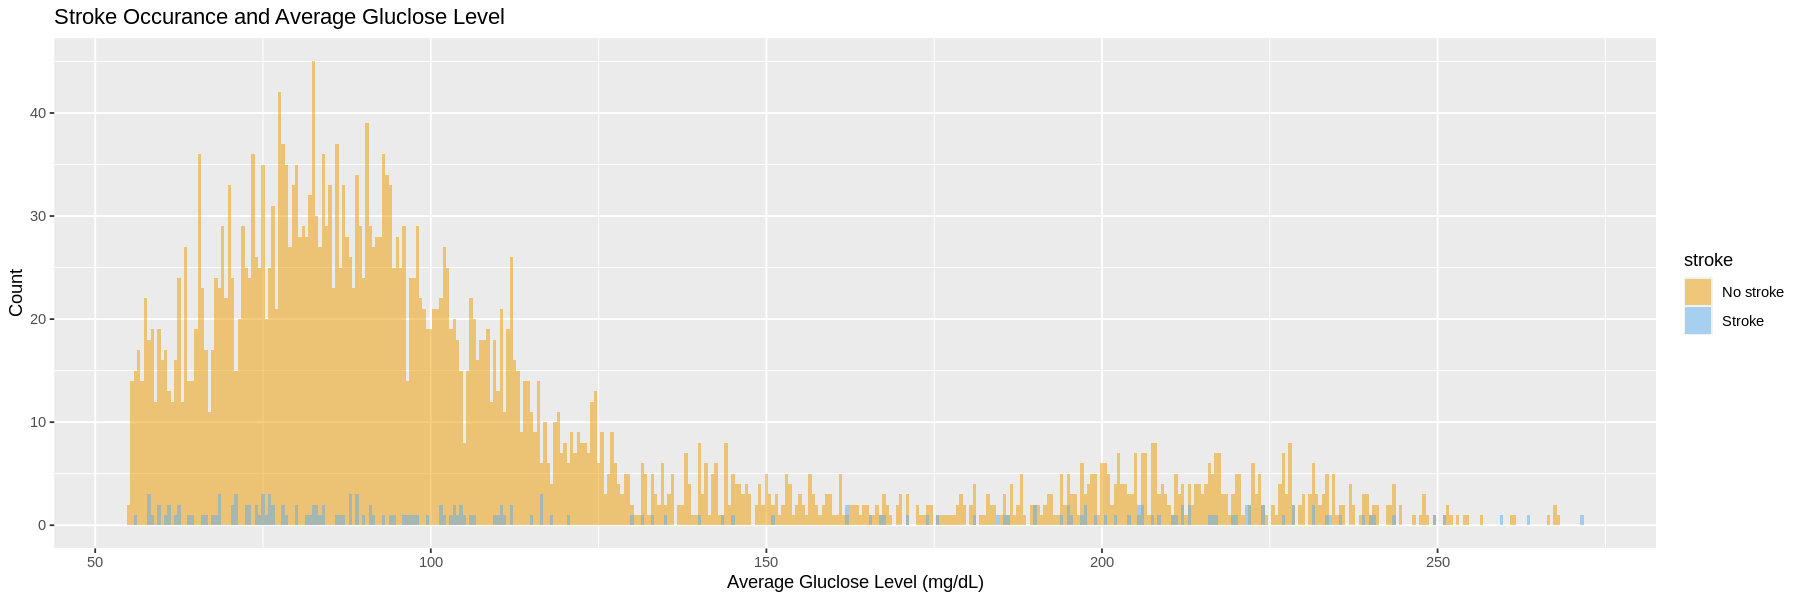

In [16]:
options(repr.plot.width = 15, repr.plot.height = 5)
glucose_plot <- ggplot(stroke_train, aes(x=avg_glucose_level, fill=stroke)) +
    geom_histogram(binwidth=.5, alpha=.5, position="identity") +
    ggtitle("Stroke Occurance and Average Gluclose Level") +
    labs(x="Average Gluclose Level (mg/dL)", y="Count") +
    scale_fill_manual(labels = c("No stroke", "Stroke"), 
                         values = c("orange2", "steelblue2"))
glucose_plot

The plot shows that for higher average glucose levels, the proportion of people with stroke are higher than those with lower average glucose levels. This indicates that there is likely a positive relationship between stroke and heart disease.

Warning message:
“Removed 158 rows containing missing values (geom_point).”


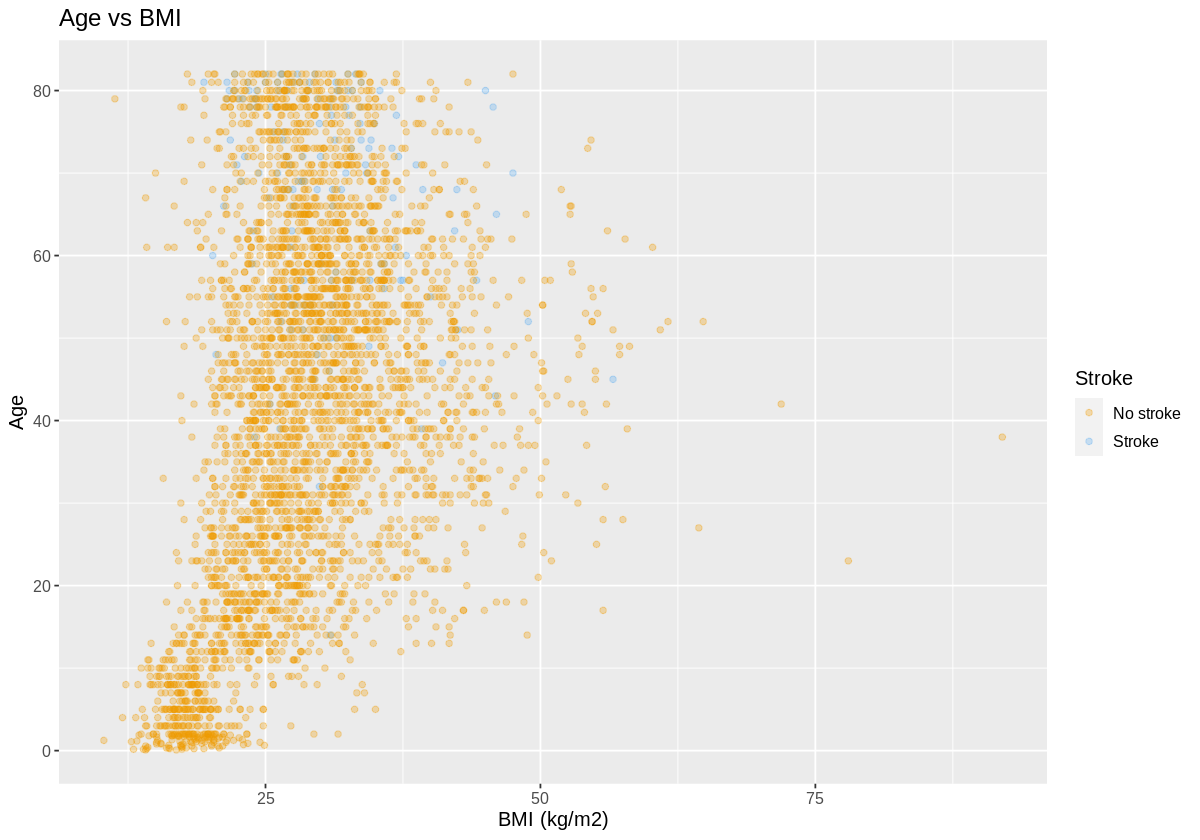

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7)
bmi_age_plot <- stroke_train %>%
  ggplot(aes(x = bmi, y = age, color = stroke)) +
  geom_point(alpha = 0.3) +
  labs(x = "BMI (kg/m2)", 
       y = "Age",
       color = "Stroke") +
      scale_color_manual(labels = c("No stroke", "Stroke"), 
                         values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12)) +
  ggtitle("Age vs BMI")
bmi_age_plot


The plot shows stroke is more common for those higher in age and bmi.


In [19]:
#Creation of correlation table 
correlation_matrix <- ggpairs(stroke_clean)
correlation_matrix 

## Methods ##
This data set provides a total of 11 attributes; gender, age, hypertension (binary), heart disease (binary), marriage status, work type, residence type, average glucose level, BMI, smoking status, and if they have suffered a stroke. Because our research question is focused on using standard medical data, we have removed marriage, work type, and residence type from our analysis.
To create the predictive model, we will use the tidymodels k-nearest neighbour classification algorithm. First, the cleaned data will be preprocessed (scaling, centering, and balancing will be applied). After the data is split into training and test sets (75/25 split), the training set will be used to create a KNN model, where the recipe uses 3 of the 5 possible variables (Age, Glucose Level, BMI, Heart Disease, Hypertension) to determine if a stroke will occur or not. This model will then be used on the test data set to predict the incidence of stroke. Finally, cross-validation of these results will be used to determine the accuracy of the model. 
This process will be repeated with all combinations of variables. The accuracy values will be compared, and the model with the highest accuracy will be selected as the best predictive model. 
To determine the best K value for the plots, we will create a to identify the maximum accuracy. Additionally, to compare the models, a bar graph will be created to compare the accuracies of different variable combinations. Once the best model is identified, it will then be visualized using a scatter plot with colour to reflect stroke incidence. 


## Expected Outcomes and Significance ##
Based on preliminary analysis, we expect that age and average glucose level are the best predictors for stroke occurrence. Our findings could have clinical applications to prevent future strokes by proactively identifying these predictors in given individuals. This way, those who are susceptible can take the necessary medical precautions, and treatments to avoid a stroke altogether. This type of analysis and modelling begs the question of what those precautions entail, as well as which ones are statistically the most effective in preventing strokes.
